In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [115]:
# Load the CSV file
df = pd.read_csv('nist-mapping.csv')

In [296]:
# Extract the required information with updated instructions
df['Function'] = df['descr'].str.extract('([A-Z]+)\.')  # Extract the Function (e.g., ID or RC)
df['Abbreviation'] = df['descr'].str.extract('([A-Z]+\.[A-Z]+)-')[0]
df['Subcategory'] = df['descr'].str.extract('(([A-Z]+\.[A-Z]+)-[0-9]+)')[0]

df['Category Name'] = df['desc'].str.split('(').str[0].str.strip()

# Filter rows with valid Abbreviation and Subcategory values
category_rows = df.dropna(subset=['Abbreviation', 'Subcategory']).copy()  # Ensure 'category_rows' is a copy
category_rows['Presence'] = category_rows['no'].gt(0)

# Create the new DataFrame with the required information
all_categories_df = pd.DataFrame({
    'Function': category_rows['Function'],
    'Category': category_rows['Category Name'],
    'Abbreviation': category_rows['Abbreviation'],
    'Subcategory': category_rows['Subcategory'],
    'Presence': category_rows['Presence']
})

all_categories_df.reset_index(drop=True, inplace=True)  # Reset index if needed

# Update NaN values in 'Category' column based on 'Abbreviation' and available 'Category' values
# Assuming a direct mapping from 'Abbreviation' to 'Category Name' can be established
abbreviation_category_map = all_categories_df.dropna(subset=['Category'])[['Abbreviation', 'Category']].drop_duplicates().set_index('Abbreviation')['Category'].to_dict()
all_categories_df['Category'] = all_categories_df['Abbreviation'].map(abbreviation_category_map)

# Define the mapping from Abbreviation to Function Category
abbreviation_category_map = {
    'ID': 'Identify',
    'DE': 'Detect',
    'PR': 'Protect',
    'RS': 'Respond',
    'RC': 'Recover'
}

# Apply mapping to update the 'Function' column
all_categories_df['Function'] = all_categories_df['Abbreviation'].str.split('.').str[0].map(abbreviation_category_map)


all_categories_df

,Function,Category,Abbreviation,Subcategory,Presence
0,Identify,Asset Management,ID.AM,ID.AM-1,True
1,Identify,Asset Management,ID.AM,ID.AM-2,True
2,Identify,Asset Management,ID.AM,ID.AM-3,True
3,Identify,Asset Management,ID.AM,ID.AM-4,True
4,Identify,Asset Management,ID.AM,ID.AM-5,True
...,...,...,...,...,...
103,Recover,Improvements,RC.IM,RC.IM-1,True
104,Recover,Improvements,RC.IM,RC.IM-2,True
105,Recover,Communications,RC.CO,RC.CO-1,False
106,Recover,Communications,RC.CO,RC.CO-2,False


In [297]:

# Assuming you have already extracted 'Function', 'Category', 'Subcategory', and 'Presence'

# Group by 'Function' and 'Category' and count the total number of subcategories and the number of fulfilled subcategories
category_counts = all_categories_df.groupby(['Function', 'Abbreviation']).agg(
    Total_Subcategories=('Subcategory', 'count'),
    Fulfilled_Subcategories=('Presence', 'sum')
)

# Calculate the percentage of fulfilled subcategories for each category
category_counts['fulfilled'] = (category_counts['Fulfilled_Subcategories'] / category_counts['Total_Subcategories']) * 100

# Drop unnecessary columns
category_counts.drop(columns=['Fulfilled_Subcategories'], inplace=True)

# Reset index to make 'Function' and 'Category' regular columns again
category_counts.reset_index(inplace=True)

category_counts

,Function,Abbreviation,Total_Subcategories,fulfilled
0,Detect,DE.AE,5,100.000000
1,Detect,DE.CM,8,100.000000
2,Detect,DE.DP,5,100.000000
3,Identify,ID.AM,6,83.333333
4,Identify,ID.BE,5,100.000000
5,Identify,ID.GV,4,0.000000
6,Identify,ID.RA,6,100.000000
7,Identify,ID.RM,3,33.333333
8,Identify,ID.SC,5,80.000000
9,Protect,PR.AC,7,100.000000


In [308]:
import matplotlib.pyplot as plt
import numpy as np

def plot_radar_chart(data, function):
    # Filter data for the given function
    function_data = data[data['Function'] == function]
    
    # Number of variables we're plotting
    num_vars = len(function_data['Abbreviation'])
    
    # Split the circle into even parts and save the angles 
    # so we know where to put each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # Make the plot continuous
    values = function_data['fulfilled'].tolist() + function_data['fulfilled'].tolist()[:1]
    angles += angles[:1]
    
    # Set figure and axis
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Adjust the position of the subplot within the figure
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    ax.fill(angles, values, alpha=0.25, label="Fulfilled Values", color=function_colors[function])
    ax.plot(angles, values, linewidth=2, color=function_colors[function])
    
    # Set yticklabels with percentage
    yticks = np.linspace(0, 100, 6)
    ax.set_yticks(yticks)
    ax.set_yticklabels(["{:.0f}%".format(y) for y in yticks])
    
    # Set xticklabels with fontsize and fontweight
    ax.set_xticks(angles[:-1])
    category_labels = [f"{abbr} ({subcategories})" for abbr, subcategories in zip(function_data['Abbreviation'], function_data['Total_Subcategories'])]
    
    # Rotate the labels based on their length and available space
    rotation = [45 if len(label) <= 10 else 90 for label in category_labels]
    
    ax.set_xticklabels(category_labels, fontsize=12, rotation=0, ha='center', va='center')
    
    # Adjust the rotation of the labels individually
    for label, angle in zip(ax.get_xticklabels(), rotation):
        label.set_rotation(angle)
        # Adjust position based on alignment
        if angle == 90:
            label.set_position((label.get_position()[0], label.get_position()[1] - 0.07))
        else:
            label.set_position((label.get_position()[0], label.get_position()[1] - 0.07))
    
    # Remove the border around the radar chart
    ax.spines['polar'].set_visible(False)
    
    # Adding a legend
    plt.tight_layout()
    
    # Export the plot as PDF
    plt.savefig(f'{function}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Define the color mapping for each function
function_colors = {
    'Detect': '#F89D1C',  # blue
    'Identify': '#4AA5DC',  # orange
    'Protect': '#835294',  # green
    'Respond': '#EB3D44',  # red
    'Recover': '#37B34A'  # purple
}


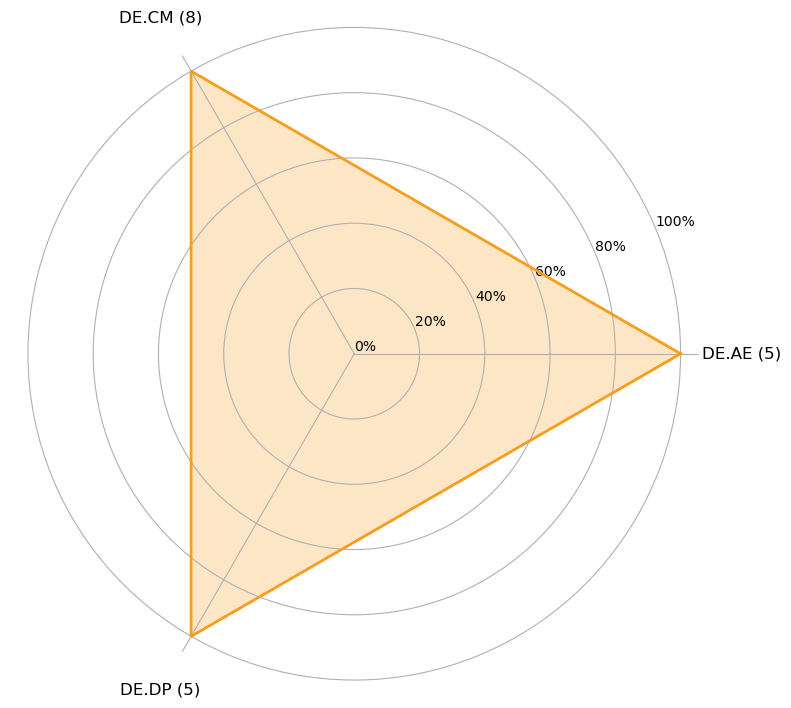

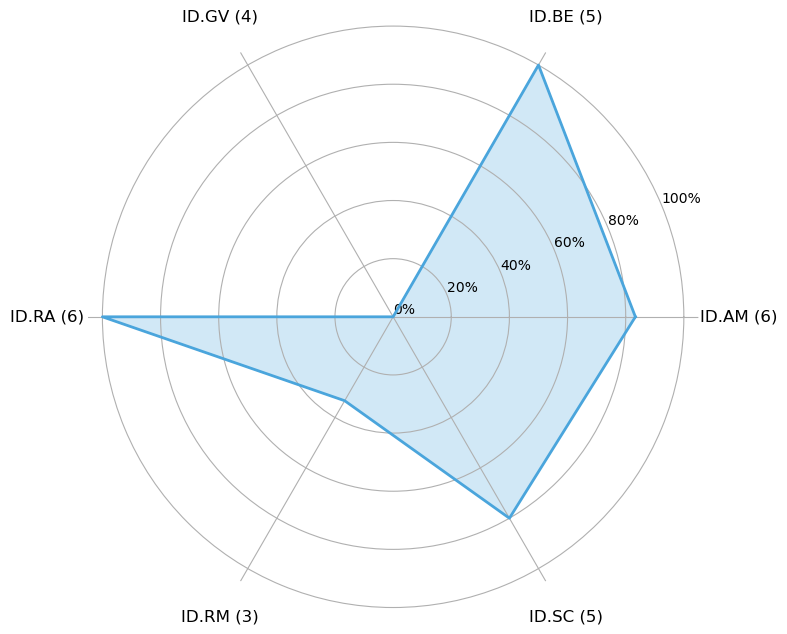

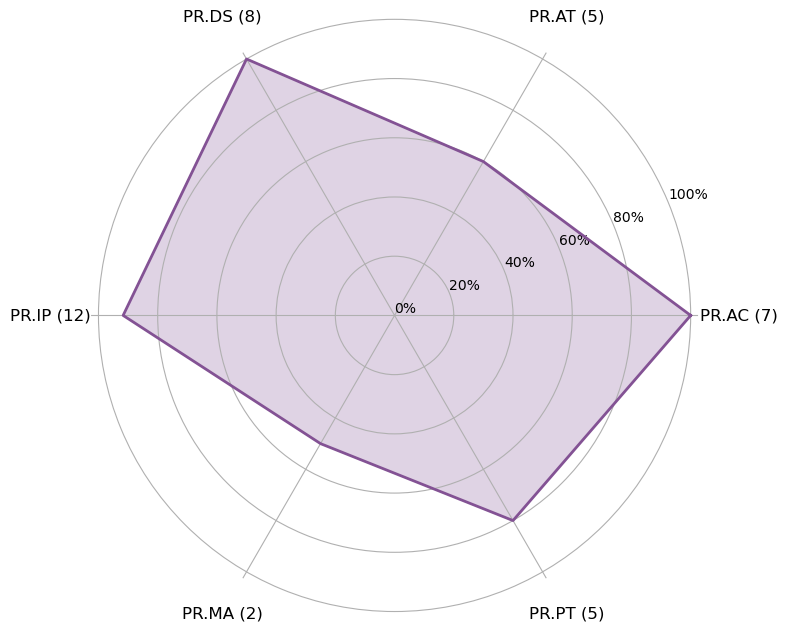

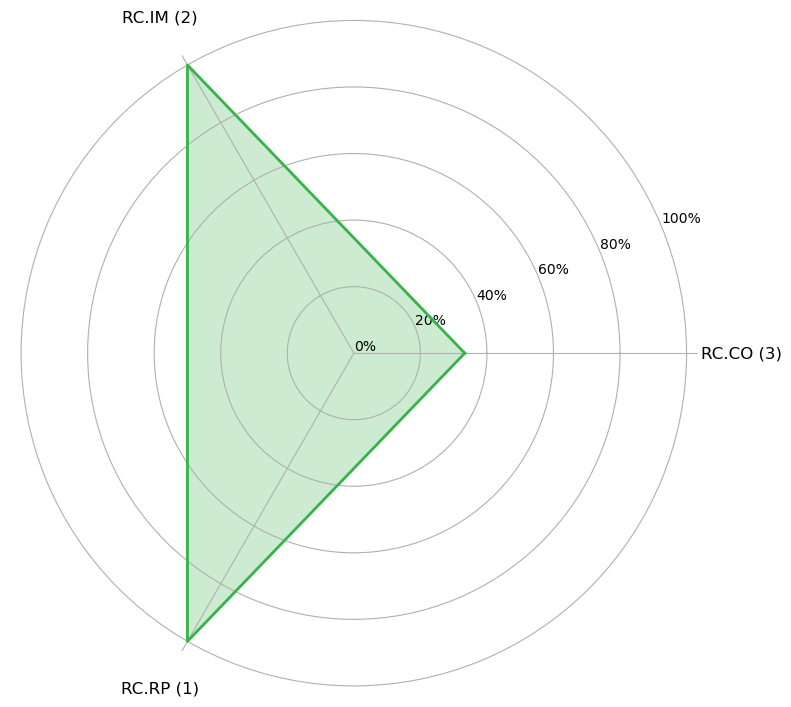

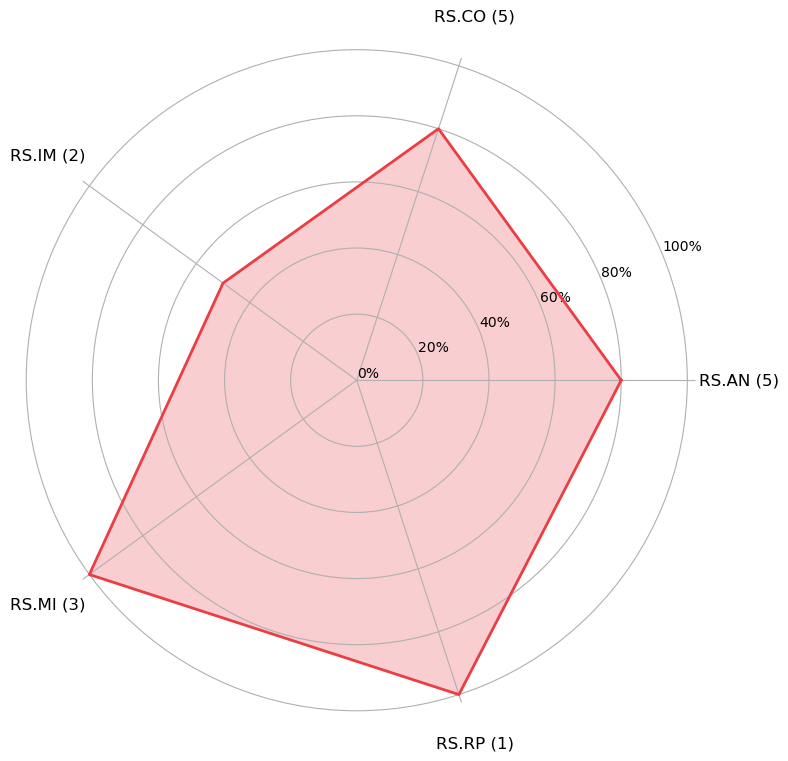

In [309]:
# Generate radar charts for each "Function"
for function, group_data in category_counts.groupby('Function'):
    plot_radar_chart(group_data, function)